In [1]:
! pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.4 MB/s eta 0:00:00


###the first version with gravity

In [ ]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
gravity = 9.8  # Gravity magnitude applied in the negative Y direction
mass = 1.5
# Define geometry for a 3D beam (length=4, width=1, height=1)
geom = dde.geometry.Cuboid([0, 0, 0], [4, 1, 1])

In [ ]:
# Boundary condition functions
def boundary_fixed(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_free(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 4.0)

# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=2)  # uz=0

import numpy as np

# Gravity force increasing step by step in the x-direction
def gravity_force(inputs, outputs, X):
    # Initialize force arrays
    force_x = -mass * np.ones_like(X[:, 0])  # pour se plier
    force_y = -gravity * np.ones_like(X[:, 1])  # Initial gravity in the negative y direction
    force_z = np.zeros_like(X[:, 2])  # No force in the z direction

    return np.stack([force_x, force_y, force_z], axis=1)


bc_gravity = dde.icbc.OperatorBC(geom, gravity_force, lambda x, _: True)  # Applies to all points

# Define the boundary conditions list
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z, bc_gravity]


In [ ]:
# Define PDE for 3D linear elasticity
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Strain components
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Shear strain components
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Stress components based on strain and material properties
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Elasticity equilibrium equations
    eq_x = dde.grad.jacobian(Sxx, X, j=0) + dde.grad.jacobian(Sxy, X, j=1) + dde.grad.jacobian(Sxz, X, j=2)
    eq_y = dde.grad.jacobian(Sxy, X, j=0) + dde.grad.jacobian(Syy, X, j=1) + dde.grad.jacobian(Syz, X, j=2)
    eq_z = dde.grad.jacobian(Sxz, X, j=0) + dde.grad.jacobian(Syz, X, j=1) + dde.grad.jacobian(Szz, X, j=2)

    return [eq_x, eq_y, eq_z]


In [ ]:
# Visualization function to show the displacement
def plot_displacement(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]

    # Plotting predicted displacement
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.quiver(points[:, 0], points[:, 1], points[:, 2],
              u_pred[:, 0], u_pred[:, 1], u_pred[:, 2], color="blue")
    ax.set_title("Predicted Displacement Field (Blue)")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

In [ ]:

# Material parameters for linear elasticity
lmbd = 1.0  # First Lamé parameter
mu = 0.5    # Second Lamé parameter (shear modulus)
gravity = 9.8  # Gravity magnitude applied in the negative Y direction
mass = 10.5

# Define geometry for a 3D beam (length=4, width=1, height=1)
geom = dde.geometry.Cuboid([0, 0, 0], [4, 1, 1])

# Boundary condition functions
def boundary_fixed(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_fixed, component=2)  # uz=0

# Gravity force increasing in the y-direction
def gravity_force(inputs, outputs, X):
    force_x =  mass*np.ones_like(X[:, 0])  # No force in x-direction
    force_y = -gravity  * np.ones_like(X[:, 1])  # Gravity in the negative y-direction
    force_z = np.zeros_like(X[:, 2])  # No force in z-direction
    return np.stack([force_x, force_y, force_z], axis=1)

bc_gravity = dde.icbc.OperatorBC(geom, gravity_force, lambda x, _: True)  # Applies to all points

# Define the boundary conditions list
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z, bc_gravity]


In [ ]:

# Define the model
data = dde.data.PDE(geom, pde, bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=1e-4)
model.train(epochs=10000)


Compiling model...
Building feed-forward neural network...
'build' took 0.059433 s

'compile' took 2.672353 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [3.31e-02, 3.43e-02, 2.93e-02, 1.36e-01, 8.31e-03, 5.03e-03, 6.88e+01]    [3.31e-02, 3.43e-02, 2.93e-02, 1.36e-01, 8.31e-03, 5.03e-03, 6.88e+01]    []  
1000      [3.93e-05, 2.76e-05, 2.57e-05, 1.06e-05, 8.44e-07, 3.30e-07, 6.88e+01]    [3.93e-05, 2.76e-05, 2.57e-05, 1.06e-05, 8.44e-07, 3.30e-07, 6.88e+01]    []  
2000      [1.35e-05, 7.56e-06, 6.80e-06, 6.63e-06, 3.98e-07, 1.94e-07, 6.88e+01]    [1.35e-05, 7.56e-06, 6.80e-06, 6.63e-06, 3.98e-07, 1.94e-07, 6.88e+01]    []  
3000      [4.99e-06, 3.42e-06, 3.38e-06, 3.99e-06, 3.79e-07, 1.67e-07, 6.88e+01]    [4.99e-06, 3.42e-06, 3.38e-06, 3.99e-06, 3.79e-07, 1.67e-07, 6.88e+01]    []  
4000      [2.06e-06, 2.16e-06, 1.74e-06, 2.44e-0

(<deepxde.model.LossHistory at 0x7d2ac15795a0>,
 <deepxde.model.TrainState at 0x7d2ac157bd30>)

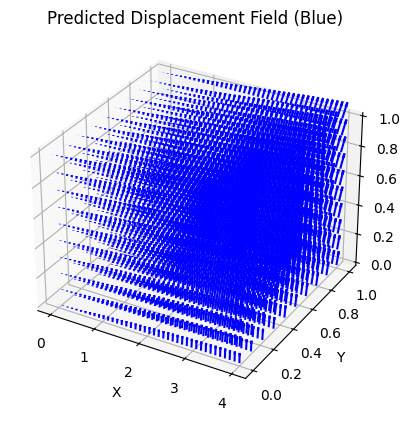

In [ ]:
# Call the plotting function
plot_displacement(model)

In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_displacement_plotly(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model.predict(points)[:, :3]
    displaced_points = points + u_pred

    # Create Scatter3d for the original grid points
    scatter_original = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Original Points'
    )

    # Create Scatter3d for the displaced grid points
    scatter_displaced = go.Scatter3d(
        x=displaced_points[:, 0],
        y=displaced_points[:, 1],
        z=displaced_points[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Displaced Points'
    )

    # Configure the layout
    layout = go.Layout(
        title='3D Predicted Displacement Field',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        legend=dict(x=0.7, y=0.95)
    )

    # Create the figure and add Scatter3d traces
    fig = go.Figure(data=[scatter_original, scatter_displaced], layout=layout)
    fig.show()

# Call the plotting function
plot_displacement_plotly(model)


# second version with force exterieur f(x)

# 3D Elasticity Simulation of a Beam using DeepXDE

This code simulates the deformation of a 3D beam under an applied force using the **DeepXDE** library, which is designed for solving partial differential equations (PDEs) with deep learning. Below is a breakdown of the code:

---

## **1. Material Properties and Geometry**
- **Material Properties**:
  - `E`: Young's modulus (2,000 Pa).
  - `nu`: Poisson's ratio (0.45).
  - `mu`: Shear modulus, derived from `E` and `nu`.
  - `lmbd`: Lamé's first parameter, derived from `E` and `nu`.

- **Beam Dimensions**:
  - `L`: Length of the beam (6 m).
  - `F`: Force magnitude applied at the free end (10,000 N).

- **Geometry**:
  - A 3D rectangular beam is defined using `dde.geometry.Cuboid` with dimensions `[L, 1, 1]`.

---

## **2. Force Application**
- A distributed force is applied at the free end (`x = L`) of the beam.
- The `force(X)` function uses `tf.where` to apply the force vector `[0, -F, 0]` only at points close to `x = L` (within a tolerance of `1e-2`). At all other points, the force is zero.

---

## **3. PDE for 3D Elasticity**
The PDE represents the **equilibrium equations** for 3D elasticity:
- **Strain Components**:
  - Normal strains (`E_xx`, `E_yy`, `E_zz`) and shear strains (`E_xy`, `E_xz`, `E_yz`) are computed using `dde.grad.jacobian`.

- **Stress Components**:
  - Stresses (`Sxx`, `Syy`, `Szz`, `Sxy`, `Sxz`, `Syz`) are derived from strains and material properties.

- **Equilibrium Equations**:
  - The equilibrium equations (`eq_x`, `eq_y`, `eq_z`) balance the divergence of the stress tensor with the applied force.
  - A scaling factor of `1e6` is used to normalize the equations for numerical stability.

---

## **4. Boundary Conditions**
- The beam is fixed at `x = 0` (all displacements are zero).
- Dirichlet boundary conditions (`bc_fixed_x`, `bc_fixed_y`, `bc_fixed_z`) enforce `ux = 0`, `uy = 0`, and `uz = 0` at the fixed end.

---

## **5. Model Definition and Training**
- **Data**:
  - The PDE, geometry, and boundary conditions are combined into a `dde.data.PDE` object.
  - `num_domain=4000` and `num_boundary=1000` specify the number of collocation points.

- **Neural Network**:
  - A feedforward neural network (`FNN`) with 3 hidden layers (50 neurons each) and `tanh` activation is used.

- **Training**:
  - The model is compiled with the Adam optimizer and a learning rate of `1e-4`.
  - Training runs for 30,000 epochs.

---

## **Key Points**
- The code solves the 3D elasticity problem for a beam under an applied force.
- Scaling (`1e6`) ensures numerical stability by normalizing the equilibrium equations.
- DeepXDE leverages neural networks to approximate the solution to the PDE.

---

This simulation is useful for understanding the deformation and stress distribution in 3D structures under mechanical loading.

In [2]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Material properties
E = 2e3 ##### Young's modulus (Pa)
nu = 0.45  ##### Poisson's ratio
mu = E / (2 * (1 + nu))  # Shear modulus
lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lamé's first parameter

# Beam dimensions and applied force
L = 6  # Length of the beam (m)
F = 1e4 #####  # Force magnitude applied at the free end (N)

# Geometry: A rectangular beam
geom = dde.geometry.Cuboid([0,0, 0], [L, 1, 1])

# Define a distributed force applied at x=L (free end of the beam)
def force(X):
    # Apply a force only at the free end (x = L) by checking if we are close to x=L with this difference 1e-2 if yes we apply [0,F,0] else we aplly [0,0,0] no changes
    return tf.where(
        tf.math.abs(X[:, 0:1] - L) < 1e-2, ##### 6,
        tf.constant([[0.0, -F, 0.0]]),  # Force vector (x=0, y=F, z=0)
        tf.zeros_like(X) #####This creates a tensor of zeros with the same shape as X. It represents no force being applied at points where the condition is not met
    )


# PDE for 3D elasticity
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Strain components
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Shear strain components ############### viens d'ou
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Stress components based on strain and material properties
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Elasticity equilibrium equations (scale these terms) WITH THE FORCE APPLIED ON ALL AXIS EQ : pour assurer que la force est correctement prise en compte dans la résolution des contraintes et déformations.

    eq_x = (
        dde.grad.jacobian(Sxx, X, j=0)
        + dde.grad.jacobian(Sxy, X, j=1)
        + dde.grad.jacobian(Sxz, X, j=2)
        + force(X)[:, 0:1]
    ) / 1e6  # Scaling factor : (force(X)) are on the order of 100000 or larger, dividing by 1e6 brings the equation back to a reasonable range (e.g., close to 1). This makes the equation easier to solve numerically
    eq_y = (
        dde.grad.jacobian(Sxy, X, j=0)
        + dde.grad.jacobian(Syy, X, j=1)
        + dde.grad.jacobian(Syz, X, j=2)
        + force(X)[:, 1:2]
    ) / 1e6  # Scaling factor
    eq_z = (
        dde.grad.jacobian(Sxz, X, j=0)
        + dde.grad.jacobian(Syz, X, j=1)
        + dde.grad.jacobian(Szz, X, j=2)
        + force(X)[:, 2:3]
    ) / 1e6  # Scaling factor

    return [eq_x, eq_y, eq_z]

# Boundary conditions
def boundary(x, on_boundary):
    # Fix the end of the beam at x = 0 (all displacements are zero)
    return on_boundary and np.isclose(x[0], 0)

bc = dde.DirichletBC(geom, lambda x: [0, 0, 0], boundary)  # Fixed end at x=0
# Fixed boundary at one end (ux=0, uy=0, uz=0)
bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary, component=0)  # ux=0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary, component=1)  # uy=0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary, component=2)  # uz=0
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z]


# Define the model
data = dde.data.PDE(geom, pde,bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model1 = dde.Model(data, net)

# Train the model
model1.compile("adam", lr=1e-4)
model1.train(epochs=50000)




No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Compiling model...
Building feed-forward neural network...
'build' took 0.059433 s

'compile' took 2.744336 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.28e-07, 1.10e-06, 5.87e-07, 4.48e-04, 4.64e-02, 7.65e-02]    [9.28e-07, 1.10e-06, 5.87e-07, 4.48e-04, 4.64e-02, 7.65e-02]    []  
1000      [1.37e-08, 8.88e-07, 4.48e-08, 4.76e-06, 2.02e-06, 5.31e-07]    [1.37e-08, 8.88e-07, 4.48e-08, 4.76e-06, 2.02e-06, 5.31e-07]    []  
2000      [5.77e-09, 8.70e-07, 1.45e-08, 3.52e-06, 1.42e-06, 2.39e-07]    [5.77e-09, 8.70e-07, 1.45e-08, 3.52e-06, 1.42e-06, 2.39e-07]    []  
3000      [3.71e-09, 8.63e-07, 7.92e-09, 2.26e-06, 8.92e-07, 1.07e-07]    [3.71e-09, 8.63e-07, 7.92e-09, 2.26e-06, 8.92e-07, 1.07e-07]    []  
4000      [2.45e-09, 8.54e-07, 5.51e-09, 1.23e-06, 5.31e-07, 8.56e-08]    [2.45e-09, 8.54e-07, 5.51e-09, 1.23e-06, 5.31e-07, 8.56e-08]    []  
5000 

(<deepxde.model.LossHistory at 0x7ad451decc50>,
 <deepxde.model.TrainState at 0x7ad4424529d0>)

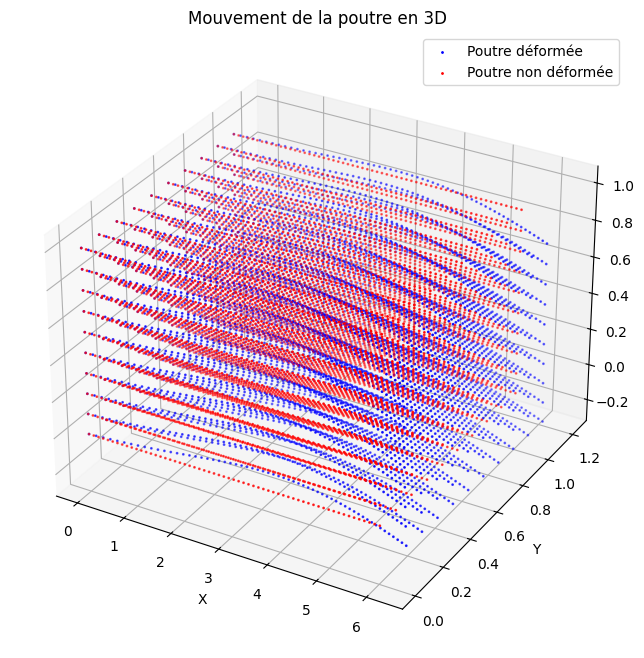

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Générer une grille de points dans la poutre
x = np.linspace(0, L, 60)  # Points le long de la longueur
y = np.linspace(0, 1, 10)  # Points le long de la hauteur
z = np.linspace(0, 1, 10)  # Points le long de la largeur
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")  # Grille 3D

# Aplatir les coordonnées pour la prédiction
points = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T

# Prédire les déplacements
u_pred = model1.predict(points)

# Ajouter les déplacements aux coordonnées initiales
X_deformed = X + u_pred[:, 0].reshape(X.shape)  # ux
Y_deformed = Y + u_pred[:, 1].reshape(Y.shape)  # uy
Z_deformed = Z + u_pred[:, 2].reshape(Z.shape)  # uz

# Visualisation 3D avec matplotlib
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Tracer la poutre déformée
ax.scatter(X_deformed, Y_deformed, Z_deformed, c="b", s=1, label="Poutre déformée")

# Tracer la poutre non déformée (optionnel)
ax.scatter(X, Y, Z, c="r", s=1, label="Poutre non déformée")

# Paramètres de la visualisation
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Mouvement de la poutre en 3D")
ax.legend()

plt.show()

In [4]:
import plotly.graph_objects as go

# Créer un objet 3D pour la poutre déformée
trace_deformed = go.Scatter3d(
    x=X_deformed.flatten(),
    y=Y_deformed.flatten(),
    z=Z_deformed.flatten(),
    mode="markers",
    marker=dict(size=2, color="blue"),
    name="Poutre déformée"
)

# Créer un objet 3D pour la poutre non déformée (optionnel)
trace_undeformed = go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    mode="markers",
    marker=dict(size=2, color="red"),
    name="Poutre non déformée"
)

# Créer la figure
fig = go.Figure(data=[trace_deformed, trace_undeformed])

# Paramètres de la visualisation
fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    title="Mouvement de la poutre en 3D"
)

# Afficher la figure
fig.show()

In [6]:
import numpy as np
import plotly.graph_objects as go

def plot_displacement_plotly(model):
    # Create a grid of points in the beam
    x = np.linspace(0, 4, 40)
    y = np.linspace(0, 1, 10)
    z = np.linspace(0, 1, 10)
    X, Y, Z = np.meshgrid(x, y, z)
    points = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

    # Predict displacements
    u_pred = model1.predict(points)[:, :3]
    displaced_points = points + u_pred

    # Create Scatter3d for the original grid points
    scatter_original = go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color='red'),
        name='Original Points'
    )

    # Create Scatter3d for the displaced grid points
    scatter_displaced = go.Scatter3d(
        x=displaced_points[:, 0],
        y=displaced_points[:, 1],
        z=displaced_points[:, 2],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name='Displaced Points'
    )

    # Configure the layout
    layout = go.Layout(
        title='3D Predicted Displacement Field',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        legend=dict(x=0.7, y=0.95)
    )

    # Create the figure and add Scatter3d traces
    fig = go.Figure(data=[scatter_original, scatter_displaced], layout=layout)
    fig.show()

# Call the plotting function
plot_displacement_plotly(model1)


# Third version with gravite

In [7]:
import deepxde as dde
import numpy as np
import tensorflow as tf

# Material properties
E = 2e3  # Young's modulus (Pa)
nu = 0.45  # Poisson's ratio
mu = E / (2 * (1 + nu))  # Shear modulus
lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lamé's first parameter

# Beam dimensions
L = 6  # Length of the beam (m)
h = 1  # Height of the beam (m)
w = 1  # Width of the beam (m)

# Gravity (body force)
rho = 0.1  # Density (kg/m³), equivalent to 100 g/m³
g = 9.81  # Acceleration due to gravity (m/s²)
f_gravity = rho * g  # Body force due to gravity (N/m³)

# Geometry: A rectangular beam
geom = dde.geometry.Cuboid([0, 0, 0], [L, h, w])

# Body force due to gravity (acts in the negative y-direction)
def force_volumique(X):
    return (tf.constant([[0.0,0.0, -f_gravity]]))  # Force in z

# PDE pour l'élasticité 3D
def pde(X, u):
    ux, uy, uz = u[:, 0:1], u[:, 1:2], u[:, 2:3]

    # Composantes de déformation
    E_xx = dde.grad.jacobian(ux, X, j=0)  # d(ux)/dx
    E_yy = dde.grad.jacobian(uy, X, j=1)  # d(uy)/dy
    E_zz = dde.grad.jacobian(uz, X, j=2)  # d(uz)/dz

    # Composantes de déformation de cisaillement
    E_xy = 0.5 * (dde.grad.jacobian(ux, X, j=1) + dde.grad.jacobian(uy, X, j=0))
    E_xz = 0.5 * (dde.grad.jacobian(ux, X, j=2) + dde.grad.jacobian(uz, X, j=0))
    E_yz = 0.5 * (dde.grad.jacobian(uy, X, j=2) + dde.grad.jacobian(uz, X, j=1))

    # Composantes de contrainte
    Sxx = E_xx * (2 * mu + lmbd) + (E_yy + E_zz) * lmbd
    Syy = E_yy * (2 * mu + lmbd) + (E_xx + E_zz) * lmbd
    Szz = E_zz * (2 * mu + lmbd) + (E_xx + E_yy) * lmbd
    Sxy = 2 * mu * E_xy
    Sxz = 2 * mu * E_xz
    Syz = 2 * mu * E_yz

    # Équations d'équilibre avec force volumique
    eq_x = (
        dde.grad.jacobian(Sxx, X, j=0)
        + dde.grad.jacobian(Sxy, X, j=1)
        + dde.grad.jacobian(Sxz, X, j=2)
        + force_volumique(X)[:, 0:1]
    ) / 1e6  # Facteur d'échelle

    eq_y = (
        dde.grad.jacobian(Sxy, X, j=0)
        + dde.grad.jacobian(Syy, X, j=1)
        + dde.grad.jacobian(Syz, X, j=2)
        + force_volumique(X)[:, 1:2]
    ) / 1e6  # Facteur d'échelle

    eq_z = (
        dde.grad.jacobian(Sxz, X, j=0)
        + dde.grad.jacobian(Syz, X, j=1)
        + dde.grad.jacobian(Szz, X, j=2)
        + force_volumique(X)[:, 2:3]
    ) / 1e6  # Facteur d'échelle

    return [eq_x, eq_y, eq_z]

# Conditions aux limites
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)  # Fixé à gauche (x = 0)

bc_fixed_x = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)  # ux = 0
bc_fixed_y = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=1)  # uy = 0
bc_fixed_z = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=2)  # uz = 0
bc = [bc_fixed_x, bc_fixed_y, bc_fixed_z]

# Définir le modèle
data = dde.data.PDE(geom, pde, bc, num_domain=4000, num_boundary=1000)
net = dde.maps.FNN([3] + [50] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

# Entraîner le modèle
model.compile("adam", lr=1e-4)
model.train(epochs=50000)

Compiling model...
Building feed-forward neural network...
'build' took 0.067958 s

'compile' took 2.315641 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [9.28e-07, 2.00e-07, 5.86e-07, 4.48e-04, 4.64e-02, 7.65e-02]    [9.28e-07, 2.00e-07, 5.86e-07, 4.48e-04, 4.64e-02, 7.65e-02]    []  
1000      [1.35e-08, 2.99e-08, 4.07e-08, 4.76e-06, 2.02e-06, 5.31e-07]    [1.35e-08, 2.99e-08, 4.07e-08, 4.76e-06, 2.02e-06, 5.31e-07]    []  
2000      [5.10e-09, 9.36e-09, 1.03e-08, 3.52e-06, 1.42e-06, 2.38e-07]    [5.10e-09, 9.36e-09, 1.03e-08, 3.52e-06, 1.42e-06, 2.38e-07]    []  
3000      [3.20e-09, 4.99e-09, 4.88e-09, 2.26e-06, 8.93e-07, 1.07e-07]    [3.20e-09, 4.99e-09, 4.88e-09, 2.26e-06, 8.93e-07, 1.07e-07]    []  
4000      [2.22e-09, 3.08e-09, 3.22e-09, 1.23e-06, 5.31e-07, 8.55e-08]    [2.22e-09, 3.08e-09, 3.22e-09, 1.23e-06, 5.31e-07, 8.55e-08]    []  
5000 

(<deepxde.model.LossHistory at 0x7ad47d167590>,
 <deepxde.model.TrainState at 0x7ad3e0502e10>)

In [8]:
# Générer une grille de points dans la poutre
x = np.linspace(0, L, 20)  # Points le long de la longueur
y = np.linspace(0, h, 10)  # Points le long de la hauteur
z = np.linspace(0, w, 10)  # Points le long de la largeur
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")  # Grille 3D

# Aplatir les coordonnées pour la prédiction
points = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T

# Prédire les déplacements
u_pred = model.predict(points)

# Ajouter les déplacements aux coordonnées initiales
X_deformed = X + u_pred[:, 0].reshape(X.shape)  # ux
Y_deformed = Y + u_pred[:, 1].reshape(Y.shape)  # uy
Z_deformed = Z + u_pred[:, 2].reshape(Z.shape)  # uz

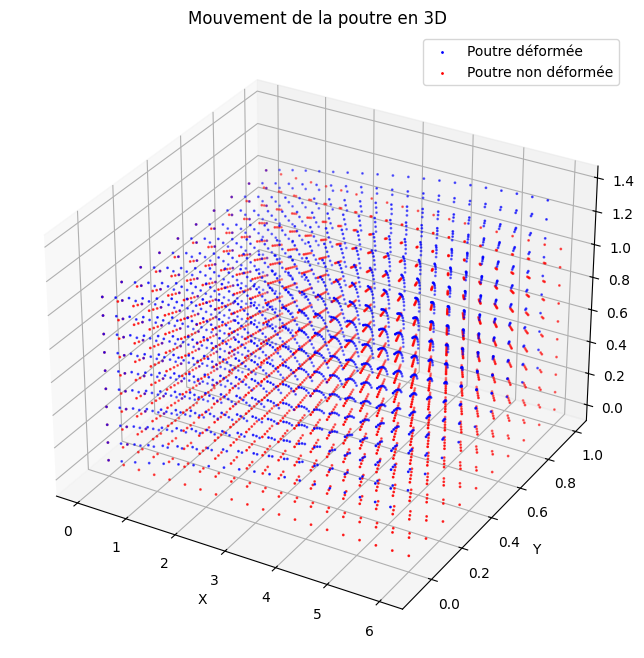

In [9]:
# Visualisation 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Tracer la poutre déformée
ax.scatter(X_deformed, Y_deformed, Z_deformed, c="b", s=1, label="Poutre déformée")

# Tracer la poutre non déformée (optionnel)
ax.scatter(X, Y, Z, c="r", s=1, label="Poutre non déformée")

# Paramètres de la visualisation
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Mouvement de la poutre en 3D")
ax.legend()

plt.show()

In [10]:
import plotly.graph_objects as go

# Créer un objet 3D pour la poutre déformée
trace_deformed = go.Scatter3d(
    x=X_deformed.flatten(),
    y=Y_deformed.flatten(),
    z=Z_deformed.flatten(),
    mode="markers",
    marker=dict(size=2, color="blue"),
    name="Poutre déformée"
)

# Créer un objet 3D pour la poutre non déformée (optionnel)
trace_undeformed = go.Scatter3d(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    mode="markers",
    marker=dict(size=2, color="red"),
    name="Poutre non déformée"
)

# Créer la figure
fig = go.Figure(data=[trace_deformed, trace_undeformed])

# Paramètres de la visualisation
fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    title="Mouvement de la poutre en 3D"
)

# Afficher la figure
fig.show()